In [2]:
import torch
from torch.autograd import Variable
from torchvision.datasets import MNIST
from EMNIST import EMNIST
from torchvision.transforms import ToTensor

In [3]:
from net import CapsNetWithReconstruction, CapsNet, ReconstructionNet

# Load model

In [4]:
n_classes = 10
# initialize network classes
capsnet = CapsNet(3, n_classes=n_classes)
reconstructionnet = ReconstructionNet(16, n_classes=n_classes)
model = CapsNetWithReconstruction(capsnet, reconstructionnet)

In [22]:
# Load trained model
MODEL_PATH = '002_model_dict_3routing_reconstructionTrue.pth'
model.load_state_dict(torch.load(MODEL_PATH))

# Load MNIST test set

In [10]:
dataset = EMNIST('../data2', "digits", train=False, transform=ToTensor())

# Helper functions

In [23]:
# (1x28x28 tensor input)
def get_digit_caps(model, image):
    input_ = Variable(image.unsqueeze(0), volatile=True)
    digit_caps, probs = model.capsnet(input_)
    return digit_caps

# takes digit_caps output and target label
def get_reconstruction(model, digit_caps, label):
    target = Variable(torch.LongTensor([label]), volatile=True)
    reconstruction = model.reconstruction_net(digit_caps, target)
    return reconstruction.data.cpu().numpy()[0].reshape(28, 28)

# create reconstructions with perturbed digit capsule
def dimension_perturbation_reconstructions(model, digit_caps, label, dimension, dim_values):
    reconstructions = []
    for dim_value in dim_values:
        digit_caps_perturbed = digit_caps.clone()
        digit_caps_perturbed[0, label, dimension] = dim_value
        reconstruction = get_reconstruction(model, digit_caps_perturbed, label)
        reconstructions.append(reconstruction)
    return reconstructions

# Visualizations

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

## Sample reconstructions

In [24]:
# Get reconstructions
images = []
reconstructions = []
for i in range(8):
    image_tensor, label = dataset[i]
    digit_caps = get_digit_caps(model, image_tensor)
    reconstruction = get_reconstruction(model, digit_caps, label)
    images.append(image_tensor.numpy()[0])
    reconstructions.append(reconstruction)

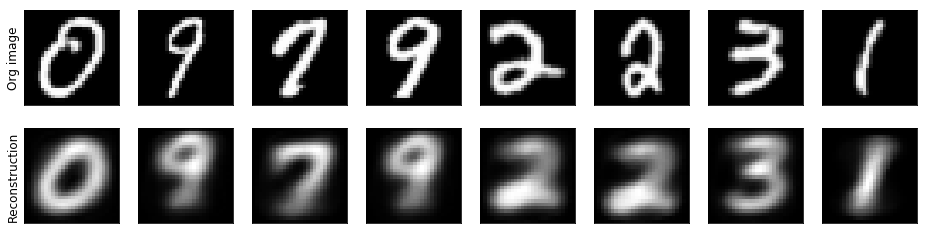

In [25]:
# Plot reconstructions
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
axs[0, 0].set_ylabel('Org image', size='large')
axs[1, 0].set_ylabel('Reconstruction', size='large')
for i in range(8):
    axs[0, i].imshow(images[i].transpose(), cmap='gray')
    axs[1, i].imshow(reconstructions[i].transpose(), cmap='gray')
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])


## What the individual dimensions of a capsule represent
We can visualize what an individual dimension of a capsule represents by perturbing values of each dimension (sec. 5.1. of the paper, figure 4).  
Each row shows the reconstruction when one of the 16 dimensions in the DigitCaps representation is tweaked by intervals of 0.05 in the range [−0.25, 0.25].

In [34]:
digit, label = dataset[4]
perturbed_reconstructions = []
perturbation_values = [0.1*i for i in range(-5, 6)]
digit_caps = get_digit_caps(model, digit)
for dimension in range(16):
    perturbed_reconstructions.append(
        dimension_perturbation_reconstructions(model, digit_caps, label,
                                               dimension, perturbation_values)
    )

In [ ]:
fig, axs = plt.subplots(16, 11, figsize=(11*1.5, 16*1.5))
for i in range(16):
    axs[i, 0].set_ylabel('dim {}'.format(i), size='large')
    for j in range(11):
        axs[i, j].imshow(perturbed_reconstructions[i][j].transpose(), cmap='gray')
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        

We can see what individual dimensions represent for digit 7,  e.g. dim6 - stroke thickness, dim11 - digit width, dim 15 - vertical shift